In [1]:
import getpass
import logging
import tempfile

from datetime import timedelta
from io import BytesIO
from pathlib import Path

import h5py

In [3]:
# Change DATA_DIR to the folder path containing h5 files
DATA_DIR = ""

RECORDING_FILENAMES = {
    ("linux", "c++"): "load_test_cpp_linux.h5",
    ("linux", "python"): "load_test_python_linux.h5",
    ("mac", "c++"): "load_test_cpp_mac.h5",
    ("mac", "python"): "load_test_python_mac.h5",
    ("win", "c++"): "load_test_cpp_win.h5",
    ("win", "python"): "load_test_python_win.h5",
}
DATASETS = ("sample_summary", "count")

def get_local_path(filename: str) -> Path:
    return Path(DATA_DIR) / Path(filename)

def get_h5_file(platform: str, language: str) -> h5py.File:
    filename = RECORDING_FILENAMES[(platform, language)]
    h5_path = get_local_path(filename)
    return h5py.File(str(h5_path), mode="r")

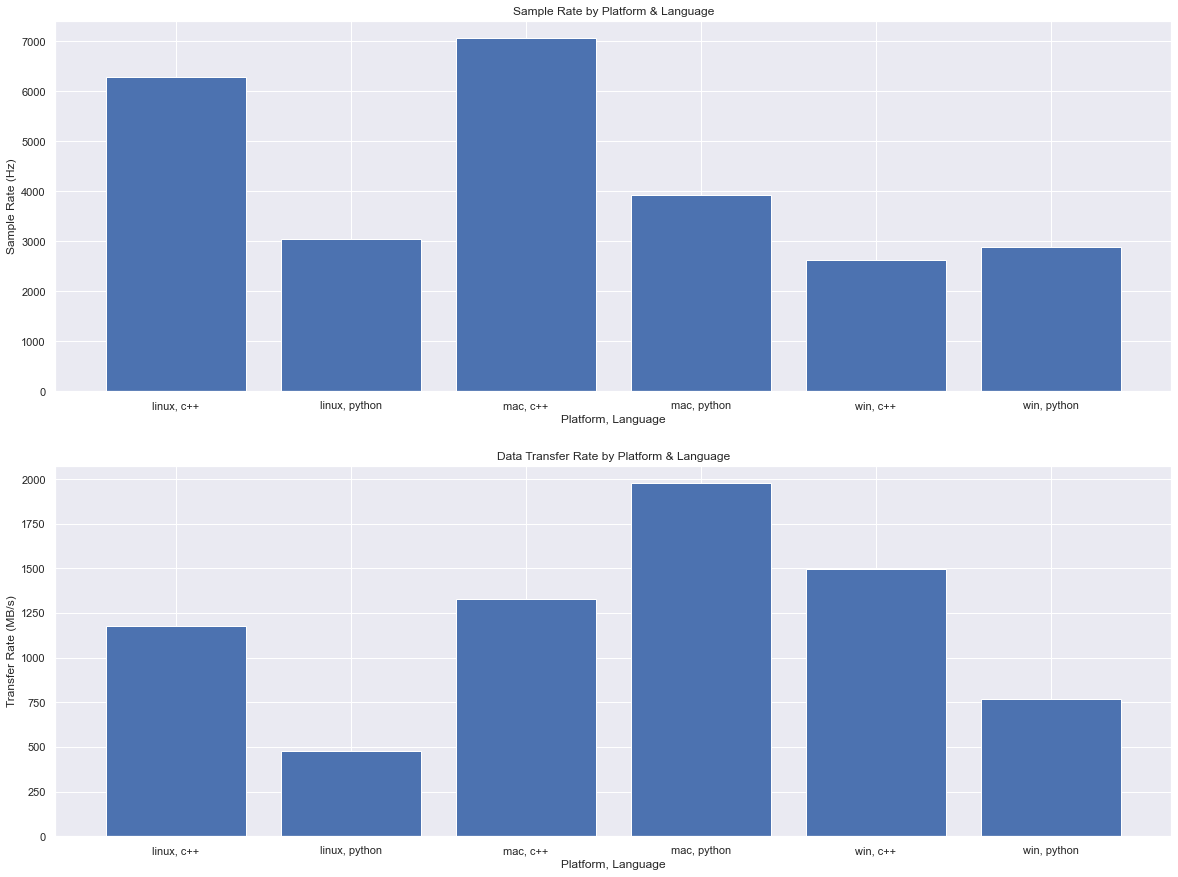

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.figure(figsize=(20,15))

x_labels = []
sample_rates = []
data_rates = []

for (platform, language) in sorted(RECORDING_FILENAMES.keys()):
    x_labels.append(f"{platform}, {language}")

    with get_h5_file(platform, language) as h5_file:
        count = h5_file["count"][h5_file["count"]["sent"] == False]

        max_sample_rate = np.max(count["count"] / count["duration"])
        sample_rates.append(max_sample_rate)

        max_data_rate = np.max(count["size"] * count["count"] / count["duration"]) / 1e6
        data_rates.append(max_data_rate)

plt.subplot(211)
plt.title("Sample Rate by Platform & Language")
plt.xlabel("Platform, Language")
plt.ylabel("Sample Rate (Hz)")
plt.bar(
    x_labels,
    sample_rates,
)
plt.subplot(212)
plt.title("Data Transfer Rate by Platform & Language")
plt.xlabel("Platform, Language")
plt.ylabel("Transfer Rate (MB/s)")
plt.bar(
    x_labels,
    data_rates,
)

plt.show()

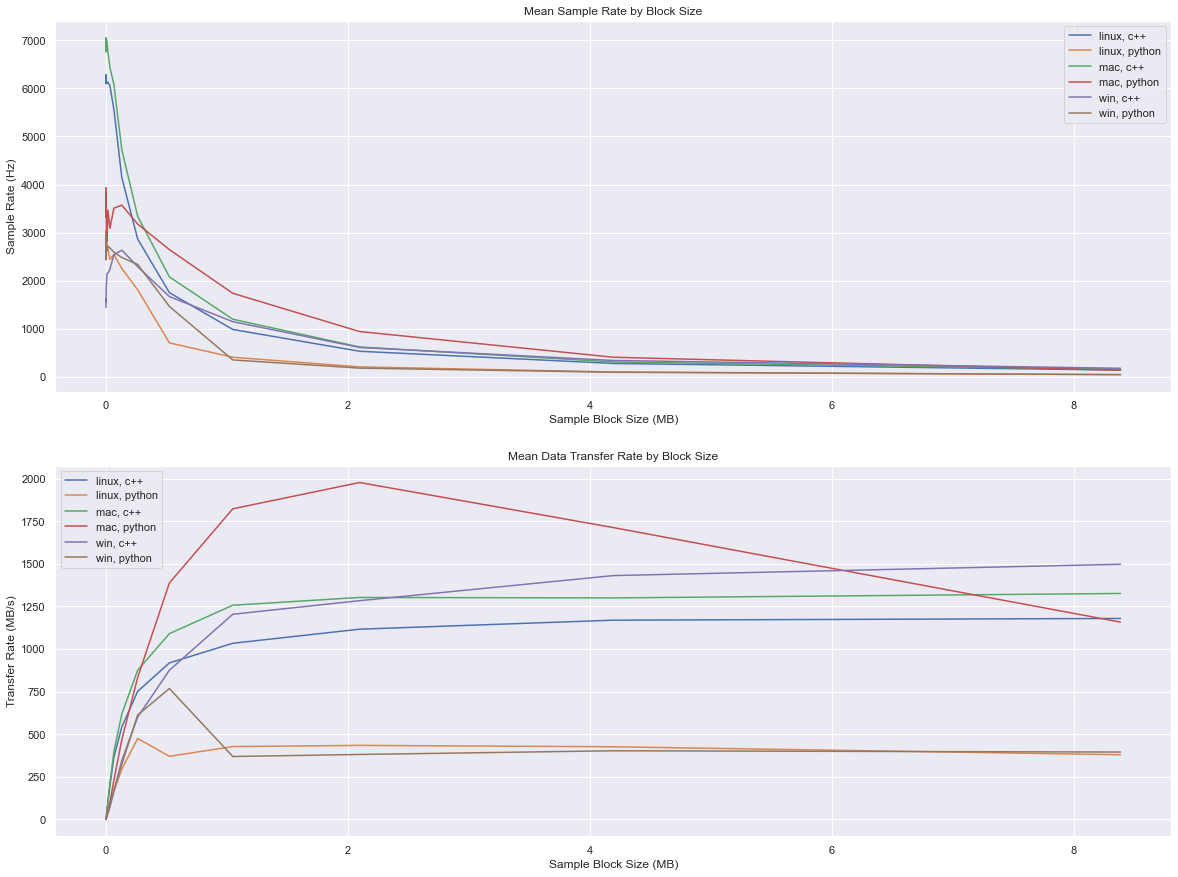

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))

plt.subplot(211)

plt.title("Mean Sample Rate by Block Size")
plt.xlabel("Sample Block Size (MB)")
plt.ylabel("Sample Rate (Hz)")
for (platform, language) in sorted(RECORDING_FILENAMES.keys()):
    with get_h5_file(platform, language) as h5_file:
        count = h5_file["count"]
        received_count = count[count["sent"] == False]
        sample_rates = received_count["count"] / received_count["duration"]
        plt.plot(received_count["size"] / 1e6, sample_rates, label=f"{platform}, {language}")

plt.legend()

plt.subplot(212)

plt.title("Mean Data Transfer Rate by Block Size")
plt.xlabel("Sample Block Size (MB)")
plt.ylabel("Transfer Rate (MB/s)")
for (platform, language) in sorted(RECORDING_FILENAMES.keys()):
    with get_h5_file(platform, language) as h5_file:
        count = h5_file["count"]
        received_count = count[count["sent"] == False]
        data_rates = received_count["size"] * received_count["count"] / received_count["duration"] / 1e6
        plt.plot(received_count["size"] / 1e6, data_rates, label=f"{platform}, {language}")

plt.legend()

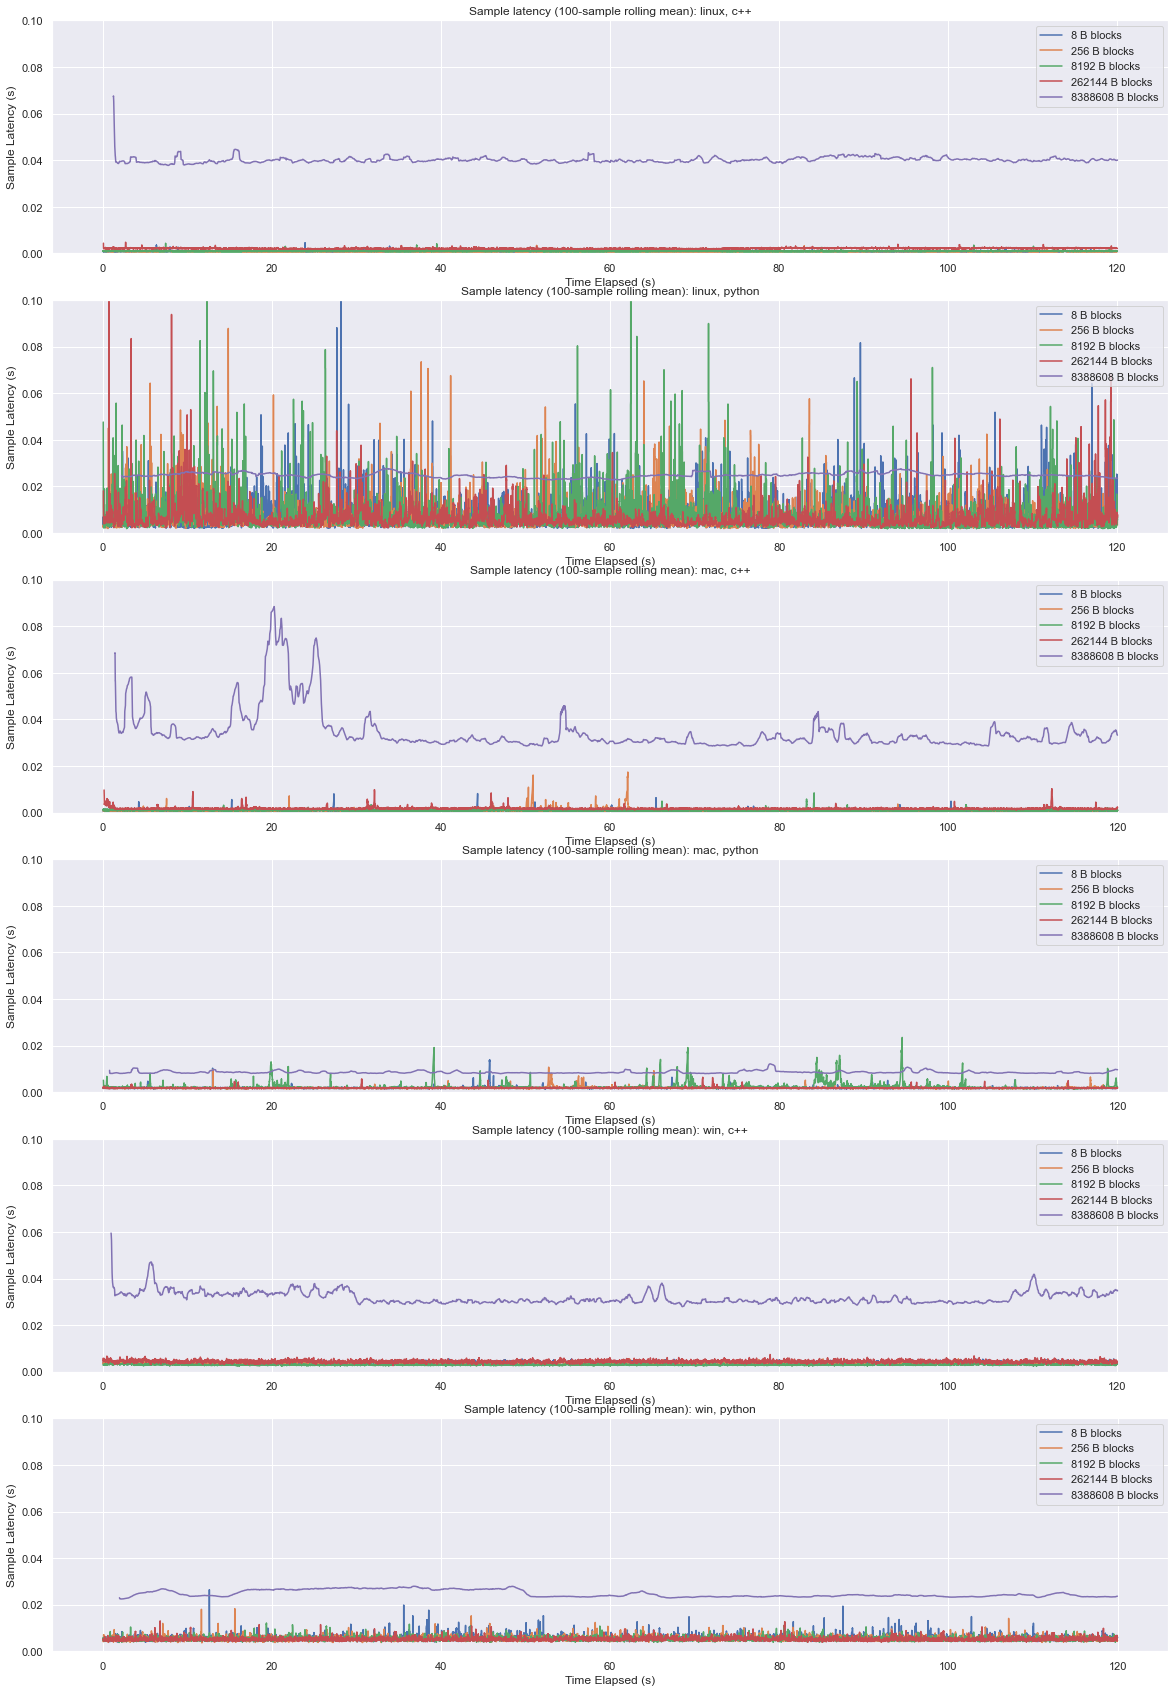

In [6]:
import pandas as pd

plt.figure(figsize=(20,30))

selected_block_sizes = (8, 256, 8192, 262144, 8388608)
window_size = 100
for i, (platform, language) in enumerate(sorted(RECORDING_FILENAMES.keys())):
    plt.subplot(len(RECORDING_FILENAMES), 1, i + 1)
    plt.title(f"Sample latency ({window_size}-sample rolling mean): {platform}, {language}")
    plt.xlabel("Time Elapsed (s)")
    plt.ylabel("Sample Latency (s)")
    plt.ylim(0, 0.1)
    for block_size in selected_block_sizes:
        with get_h5_file(platform, language) as h5_file:
            sample_summary = h5_file[f"sample_summary_{block_size}"]
            start_time = np.min(sample_summary["sent_timestamp"])
            rolling_latency = pd.Series(sample_summary["received_timestamp"] - sample_summary["sent_timestamp"]).rolling(window=window_size).mean().values
            plt.plot(sample_summary["received_timestamp"] - start_time, rolling_latency, label=f"{block_size} B blocks")
    plt.legend()